# Antarctic SLP trends

Author: Ziqi Yin

Last edited: Jul 29, 2025

## Description

SLP trends:
- Simulation: CESM2-LE, CESM2-LE*, CESM2-TPACE, O'Connor24
- Method: epoch difference of 1976:2000 minus 1901:1925
- Region: 40S-90S

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

import matplotlib.patches as mpatches

# For regridding
import os
import ESMF
import xesmf as xe

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
%pip install xesmf

Note: you may need to restart the kernel to use updated packages.


In [2]:
def calculate_AIS_PSL(path, fn_p1, yr_s, yr_e):
    
    ## Read data
    fn_PSL = fn_p1+'.PSL.'+str(yr_s)+'01-'+str(yr_e)+'12.nc'
    PSL = xr.open_dataset(path+fn_PSL).PSL
    
    ## Correct time
    dates = pd.date_range(str(yr_s)+'-01-01', periods=(yr_e-yr_s+1)*12, freq='M')
    PSL['time'] = dates

    # Plot period (currently same to the whole period)
    PSL_monthly = PSL.sel(time=slice(str(yr_s)+'-01-01', str(yr_e)+'-12-31')) #[Pa]
    PSL_yearly = (PSL_monthly * PSL_monthly.time.dt.days_in_month).groupby(PSL_monthly.time.dt.year).sum() /365 #[Pa]

    return PSL_yearly

## Read data

### Ensemble mean

In [3]:
## PSL
# O'Connor reconstruction (1900-2005)
path = '/glade/work/dschneid/oconnor/'

#fn_PSL_OC = 'lens_recon_psl_1900_2005_ens_mean.nc' # version 1 - O'Connor21
fn_PSL_OC = 'LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom_psl.nc' # version 2 - O'Connor24
#fn_PSL_OC = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom_psl.nc' # version 3 - O'Connor24-TPACE
PSL_OC = xr.open_dataset(path+fn_PSL_OC).psl[:,0,:,:] #[Pa]
lat_OC = np.array(PSL_OC.lat)
lon_OC = np.array(PSL_OC.lon)

#CESM2-LE (50 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/'

fn_PSL_LE = 'b.e21.BHISTsmbb.f09_g17.LE2.EM1-50.cam.h0.PSL.185001-210012.nc'
PSL_LE = xr.open_dataset(path+fn_PSL_LE).PSL #[Pa]
lat = np.array(PSL_LE.lat)
lon = np.array(PSL_LE.lon)

# CESM2-LE (10 members, 1850-2100, to compare with TPACE)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/TPACE_subset/'

fn_PSL_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10-tpace.cam.h0.PSL.185001-210012.nc'
PSL_LE10 = xr.open_dataset(path+fn_PSL_LE10).PSL

# CESM2-TPACE (10 members, 1880-2019)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/tropical_pacific_pacemaker/'

fn_PSL_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.cam.h0.PSL.188001-201912.nc'
PSL_TPACE = xr.open_dataset(path+fn_PSL_TPACE).PSL

In [4]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='M')
PSL_LE['time'] = dates
PSL_LE10['time'] = dates

dates = pd.date_range("1880-01-01", periods=140*12, freq='M')
PSL_TPACE['time'] = dates

/glade/derecho/scratch/ziqiyin/tmp/ipykernel_111829/148557540.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("1850-01-01", periods=251*12, freq='M')
/glade/derecho/scratch/ziqiyin/tmp/ipykernel_111829/148557540.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("1880-01-01", periods=140*12, freq='M')


In [5]:
## Select time period
PSL_LE = PSL_LE.sel(time=slice("1901-01-01", "2000-12-31"))
PSL_LE10 = PSL_LE10.sel(time=slice("1901-01-01", "2000-12-31"))

### Ensembles

In [54]:
# CESM2-LE
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/'
yr_s = 1850
yr_e = 2100
PSL_LE_yearly = np.zeros((50, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['1011.001', '1031.002', '1051.003', '1071.004', '1091.005', '1111.006', '1131.007', '1151.008', '1171.009', '1191.010',
      '1231.011', '1231.012', '1231.013', '1231.014', '1231.015', '1231.016', '1231.017', '1231.018', '1231.019', '1231.020',
      '1251.011', '1251.012', '1251.013', '1251.014', '1251.015', '1251.016', '1251.017', '1251.018', '1251.019', '1251.020',
      '1281.011', '1281.012', '1281.013', '1281.014', '1281.015', '1281.016', '1281.017', '1281.018', '1281.019', '1281.020',
      '1301.011', '1301.012', '1301.013', '1301.014', '1301.015', '1301.016', '1301.017', '1301.018', '1301.019', '1301.020']

for i in range(50):
    fn_p1 = 'b.e21.BHISTsmbb.f09_g17.LE2-'+mn[i]+'.cam.h0'
    PSL_LE_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [55]:
## Save as netcdf file
df = xr.DataArray(PSL_LE_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,51)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_LE_ensemble_yearly.nc')

In [6]:
PSL_LE_ensemble_yearly = xr.open_dataset('../../PSL_LE_ensemble_yearly.nc').PSL

In [14]:
# CESM2-TPACE
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/tropical_pacific_pacemaker/'
yr_s = 1880
yr_e = 2019
PSL_TPACE_yearly = np.zeros((10, yr_e-yr_s+1, len(lat), len(lon)))

for i in range(10):
    fn_p1 = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.'+'{:03d}'.format(i+1)+'.cam.h0'
    PSL_TPACE_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [15]:
# Save as netcdf file
df = xr.DataArray(PSL_TPACE_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,11)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_TPACE_ensemble_yearly.nc')

In [7]:
PSL_TPACE_ensemble_yearly = xr.open_dataset('../../PSL_TPACE_ensemble_yearly.nc').PSL

In [8]:
# CESM2-LE*
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/TPACE_subset/'
yr_s = 1850
yr_e = 2100
PSL_LE10_yearly = np.zeros((10, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010']

for i in range(10):
    fn_p1 = 'b.e21.BHISTcmip6.f09_g17.LE2-'+mn[i]+'.cam.h0'
    PSL_LE10_yearly[i,:,:,:] = calculate_AIS_PSL(path, fn_p1, yr_s, yr_e)

In [9]:
# Save as netcdf file
df = xr.DataArray(PSL_LE10_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,11)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='PSL', attrs=dict(longname='annual mean sea level pressure', units='Pa'))
df.to_netcdf('PSL_LE10_ensemble_yearly.nc')

In [8]:
PSL_LE10_ensemble_yearly = xr.open_dataset('../../PSL_LE10_ensemble_yearly.nc').PSL

## Calculate

### Ensemble mean

In [9]:
## Calculate yearly mean SMB
days_in_month = PSL_LE.time.dt.days_in_month
year = PSL_LE.time.dt.year
PSL_LE_monthly = PSL_LE #[Pa]
PSL_LE_yearly = (PSL_LE_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_LE10_monthly = PSL_LE10 #[Pa]
PSL_LE10_yearly = (PSL_LE10_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_TPACE_monthly = PSL_TPACE #[Pa]
PSL_TPACE_yearly = (PSL_TPACE_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

PSL_OC_yearly = PSL_OC

In [10]:
## Calculate trend using epoch difference
PSL_LE_trend = (PSL_LE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_LE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_LE10_trend = (PSL_LE10_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_LE10_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_TPACE_trend = (PSL_TPACE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_TPACE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_OC_trend = (PSL_OC_yearly.sel(time=slice('1976','2000')).mean(dim='time') - PSL_OC_yearly.sel(time=slice('1901','1925')).mean(dim='time')) / 75 #[Pa/yr]

# Set back nan values
PSL_LE_trend = np.where(PSL_LE_trend != 0, PSL_LE_trend, np.NaN)
PSL_LE10_trend = np.where(PSL_LE10_trend != 0, PSL_LE10_trend, np.NaN)
PSL_TPACE_trend = np.where(PSL_TPACE_trend != 0, PSL_TPACE_trend, np.NaN)
PSL_OC_trend = np.where(PSL_OC_trend != 0, PSL_OC_trend, np.NaN)

In [11]:
# Add cyclic points
PSL_LE_trend_full, lon_full = add_cyclic_point(PSL_LE_trend, coord=lon)
PSL_LE10_trend_full, lon_full = add_cyclic_point(PSL_LE10_trend, coord=lon)
PSL_TPACE_trend_full, lon_full = add_cyclic_point(PSL_TPACE_trend, coord=lon)
PSL_OC_trend_full, lon_OC_full = add_cyclic_point(PSL_OC_trend, coord=lon_OC)

In [12]:
# (Check) TPACE - LE*
PSL_TPACE_LE10_ensemble_yearly = PSL_TPACE_ensemble_yearly.sel(year=(slice(1901, 2000))) - PSL_LE10_ensemble_yearly.sel(year=(slice(1901, 2000)))
PSL_TPACE_LE10_yearly = PSL_TPACE_LE10_ensemble_yearly.mean(dim='num')
PSL_TPACE_LE10_trend = (PSL_TPACE_LE10_yearly.sel(year=slice('1976','2000')).mean(dim='year') - PSL_TPACE_LE10_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]
PSL_TPACE_LE10_trend = np.where(PSL_TPACE_LE10_trend != 0, PSL_TPACE_LE10_trend, np.NaN)

### Ensembles

In [13]:
PSL_LE_ensemble_trend = np.zeros((50,len(lat),len(lon)))
PSL_LE_ensemble_trend_full = np.zeros((50,len(lat),len(lon)+1))

for i in range(50):
    # Calculate trend using epoch difference
    PSL_LE_ensemble_trend[i,:,:] = (PSL_LE_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - PSL_LE_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]

    # Add cyclic points
    PSL_LE_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(PSL_LE_ensemble_trend[i,:,:], coord=lon)

    PSL_LE_ensemble_trend_full[i,:,:] = np.where(PSL_LE_ensemble_trend_full[i,:,:] != 0, PSL_LE_ensemble_trend_full[i,:,:], np.NaN)

In [14]:
PSL_TPACE_ensemble_trend = np.zeros((10,len(lat),len(lon)))
PSL_TPACE_ensemble_trend_full = np.zeros((10,len(lat),len(lon)+1))

for i in range(10):
    # Calculate trend using epoch difference
    PSL_TPACE_ensemble_trend[i,:,:] = (PSL_TPACE_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - PSL_TPACE_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]

    # Add cyclic points
    PSL_TPACE_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(PSL_TPACE_ensemble_trend[i,:,:], coord=lon)

    PSL_TPACE_ensemble_trend_full[i,:,:] = np.where(PSL_TPACE_ensemble_trend_full[i,:,:] != 0, PSL_TPACE_ensemble_trend_full[i,:,:], np.NaN)

In [15]:
PSL_LE10_ensemble_trend = np.zeros((10,len(lat),len(lon)))
PSL_LE10_ensemble_trend_full = np.zeros((10,len(lat),len(lon)+1))

for i in range(10):
    # Calculate trend using epoch difference
    PSL_LE10_ensemble_trend[i,:,:] = (PSL_LE10_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - PSL_LE10_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[Pa/yr]

    # Add cyclic points
    PSL_LE10_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(PSL_LE10_ensemble_trend[i,:,:], coord=lon)

    PSL_LE10_ensemble_trend_full[i,:,:] = np.where(PSL_LE10_ensemble_trend_full[i,:,:] != 0, PSL_LE10_ensemble_trend_full[i,:,:], np.NaN)

### Regrid

#### xESMF, bilinear method

In [16]:
regridder_OC2f09 = xe.Regridder(PSL_OC[0,:,:], PSL_LE[0,:,:], "bilinear") # have to use the data file which contains 'lat','lon'

PSL_OC2f09_trend = regridder_OC2f09(PSL_OC_trend)

#### ESMPy, 1st order conservative method (not used)

In [19]:
# Here ESMPy is used to plot SE grids, since it seems xESMF does not support remapping to unstructred mesh now
ESMF.Manager(debug=True);

In [21]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)

In [79]:
## Generate coordinate info
# f09
f09_lons = np.tile(lon, (192, 1)).T
f09_lats = np.tile(lat, (288, 1))
f09_centers = np.stack((f09_lons, f09_lats))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

# OC21
OC_lons = np.tile(lon_OC, (181, 1)).T
OC_lats = np.tile(lat_OC, (360, 1))
OC_centers = np.stack((OC_lons, OC_lats))

OC_lon_corner = lon_OC[:] - 0.5
OC_lon_corner = np.append(OC_lon_corner, lon_OC[-1]+0.5)
OC_lon_corners = np.tile(OC_lon_corner, (182, 1)).T
OC_lat_corner = lat_OC - 0.5
OC_lat_corner = np.append(OC_lat_corner, lat_OC[-1])
OC_lat_corner[0] += 0.5
OC_lat_corners = np.tile(OC_lat_corner, (361, 1))
OC_corners = np.stack((OC_lon_corners, OC_lat_corners))

In [ ]:
def regrid_con_grid_to_grid(centers_gridin, corners_gridin, precip_gridin, centers_gridout, corners_gridout): 

    gridin = ESMF.Grid(np.array(precip_gridin.T.shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridin_lon = gridin.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridin_lat = gridin.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridin_lon[...] = centers_gridin[0]
    gridin_lat[...] = centers_gridin[1]
    gridin_lon_cor = gridin.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridin_lat_cor = gridin.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridin_lon_cor[...] = corners_gridin[0]
    gridin_lat_cor[...] = corners_gridin[1]
    srcfield = ESMF.Field(gridin)
    srcfield.data[:] = precip_gridin.T #kg m-2 s-1
    
    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

## Correlation with reanalysis

In [17]:
# OC21
PSL_OC2f09_trend_flat = PSL_OC2f09_trend[:54,:].flatten()

# CESM2-LE ensemble mean
PSL_LE_trend_flat = PSL_LE_trend[:54,:].flatten()
PSL_LE_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_LE_trend_flat)

# CESM2-LE* ensemble mean
PSL_LE10_trend_flat = PSL_LE10_trend[:54,:].flatten()
PSL_LE10_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_LE10_trend_flat)

# CESM2-TPACE ensemble mean
PSL_TPACE_trend_flat = PSL_TPACE_trend[:54,:].flatten()
PSL_TPACE_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_TPACE_trend_flat)

print(PSL_OC2f09_trend_flat.shape)
print(PSL_TPACE_trend_flat.shape)

(15552,)
(15552,)


In [18]:
# (Check) CESM2-TPACE - CESM2-LE* ensemble mean
PSL_TPACE_LE10_trend_flat = PSL_TPACE_LE10_trend[:54,:].flatten()
PSL_TPACE_LE10_trend_cor, _ = pearsonr(PSL_OC2f09_trend_flat, PSL_TPACE_LE10_trend_flat)
print(PSL_TPACE_LE10_trend_cor)

-0.4188065699183148


In [19]:
# CESM2-LE ensemble members
PSL_LE_ensemble_trend_cor = np.zeros(50)

for i in range(50):
    PSL_LE_ensemble_trend_flat = PSL_LE_ensemble_trend[i,:54,:].flatten()
    PSL_LE_ensemble_trend_cor[i], _ = pearsonr(PSL_OC2f09_trend_flat, PSL_LE_ensemble_trend_flat)

In [20]:
# CESM2-TPACE ensemble members
PSL_TPACE_ensemble_trend_cor = np.zeros(10)

for i in range(10):
    PSL_TPACE_ensemble_trend_flat = PSL_TPACE_ensemble_trend[i,:54,:].flatten()
    PSL_TPACE_ensemble_trend_cor[i], _ = pearsonr(PSL_OC2f09_trend_flat, PSL_TPACE_ensemble_trend_flat)

In [21]:
# CESM2-LE* ensemble members
PSL_LE10_ensemble_trend_cor = np.zeros(10)

for i in range(10):
    PSL_LE10_ensemble_trend_flat = PSL_LE10_ensemble_trend[i,:54,:].flatten()
    PSL_LE10_ensemble_trend_cor[i], _ = pearsonr(PSL_OC2f09_trend_flat, PSL_LE10_ensemble_trend_flat)

## Plot

### Ensemble mean

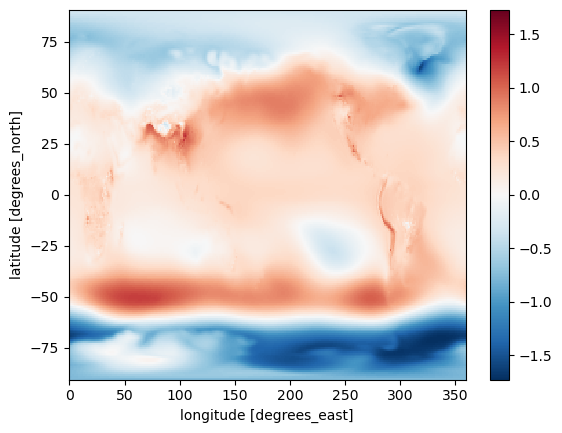

In [27]:
PSL_LE_trend.plot();

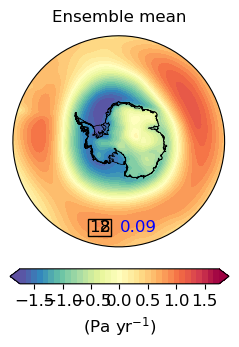

In [135]:
fig=plt.figure(figsize=(3,3))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-1.75, 1.76, 0.1)
ticks_PSL = np.arange(-1.5, 1.51, 0.5)

size_title = 12
size_label = 12
size_tick = 12
size_text = 12

cmap1='Spectral_r'
cmap2='BrBG_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

ax1.set_title('Ensemble mean', pad=12, fontsize=size_title)

ax1.text(-1700000, -5200000, '12', fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
ax1.text(-1100000, -5200000, '8', fontsize=size_text)
ax1.text(50000, -5200000, '0.09', fontsize=size_text, color='b')

#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.05]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('(Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.07,
                    hspace=0.09)

plt.subplots_adjust(bottom=0.19)
#plt.savefig('map_AIS_PSL_trend_CESM2-LE_epoch.jpg',dpi=300)
plt.show()

### Ensembles

#### version1 - O'Connor21

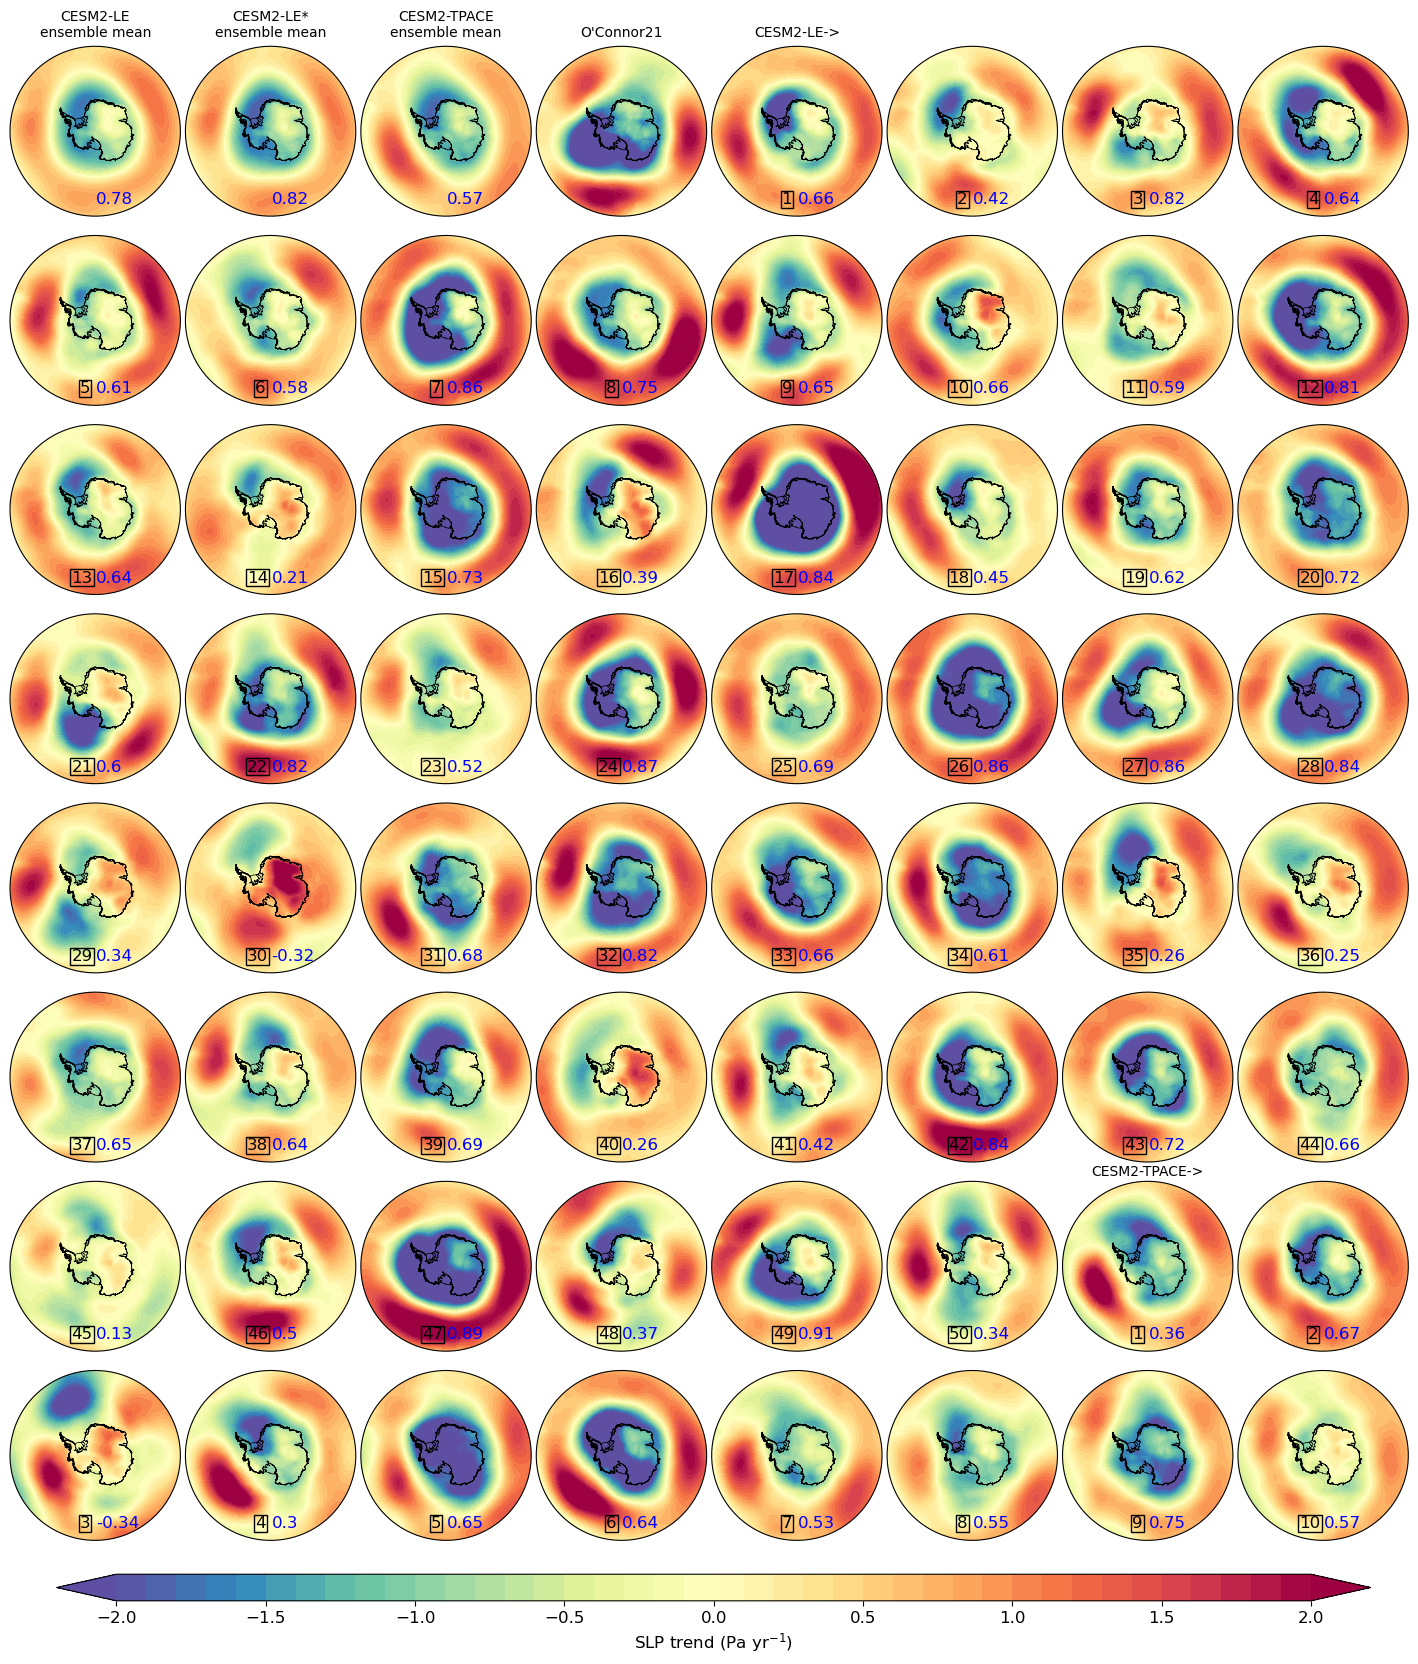

In [136]:
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10
size_label = 12
size_tick = 12
size_text = 12

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('CESM2-LE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax1.text(50000, -5200000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('CESM2-LE*\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax2.text(50000, -5200000, round(PSL_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('CESM2-TPACE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax3.text(50000, -5200000, round(PSL_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('O\'Connor21', pad=8, fontsize=size_title)


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


# CESM2-TPACE
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_TPACE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-TPACE->', pad=5, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_TPACE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('map_AIS_PSL_trend_CESM2-LE_TPACE_ensemble_OC_epoch.jpg',dpi=300)
plt.show()

#### version2 - O'Connor24

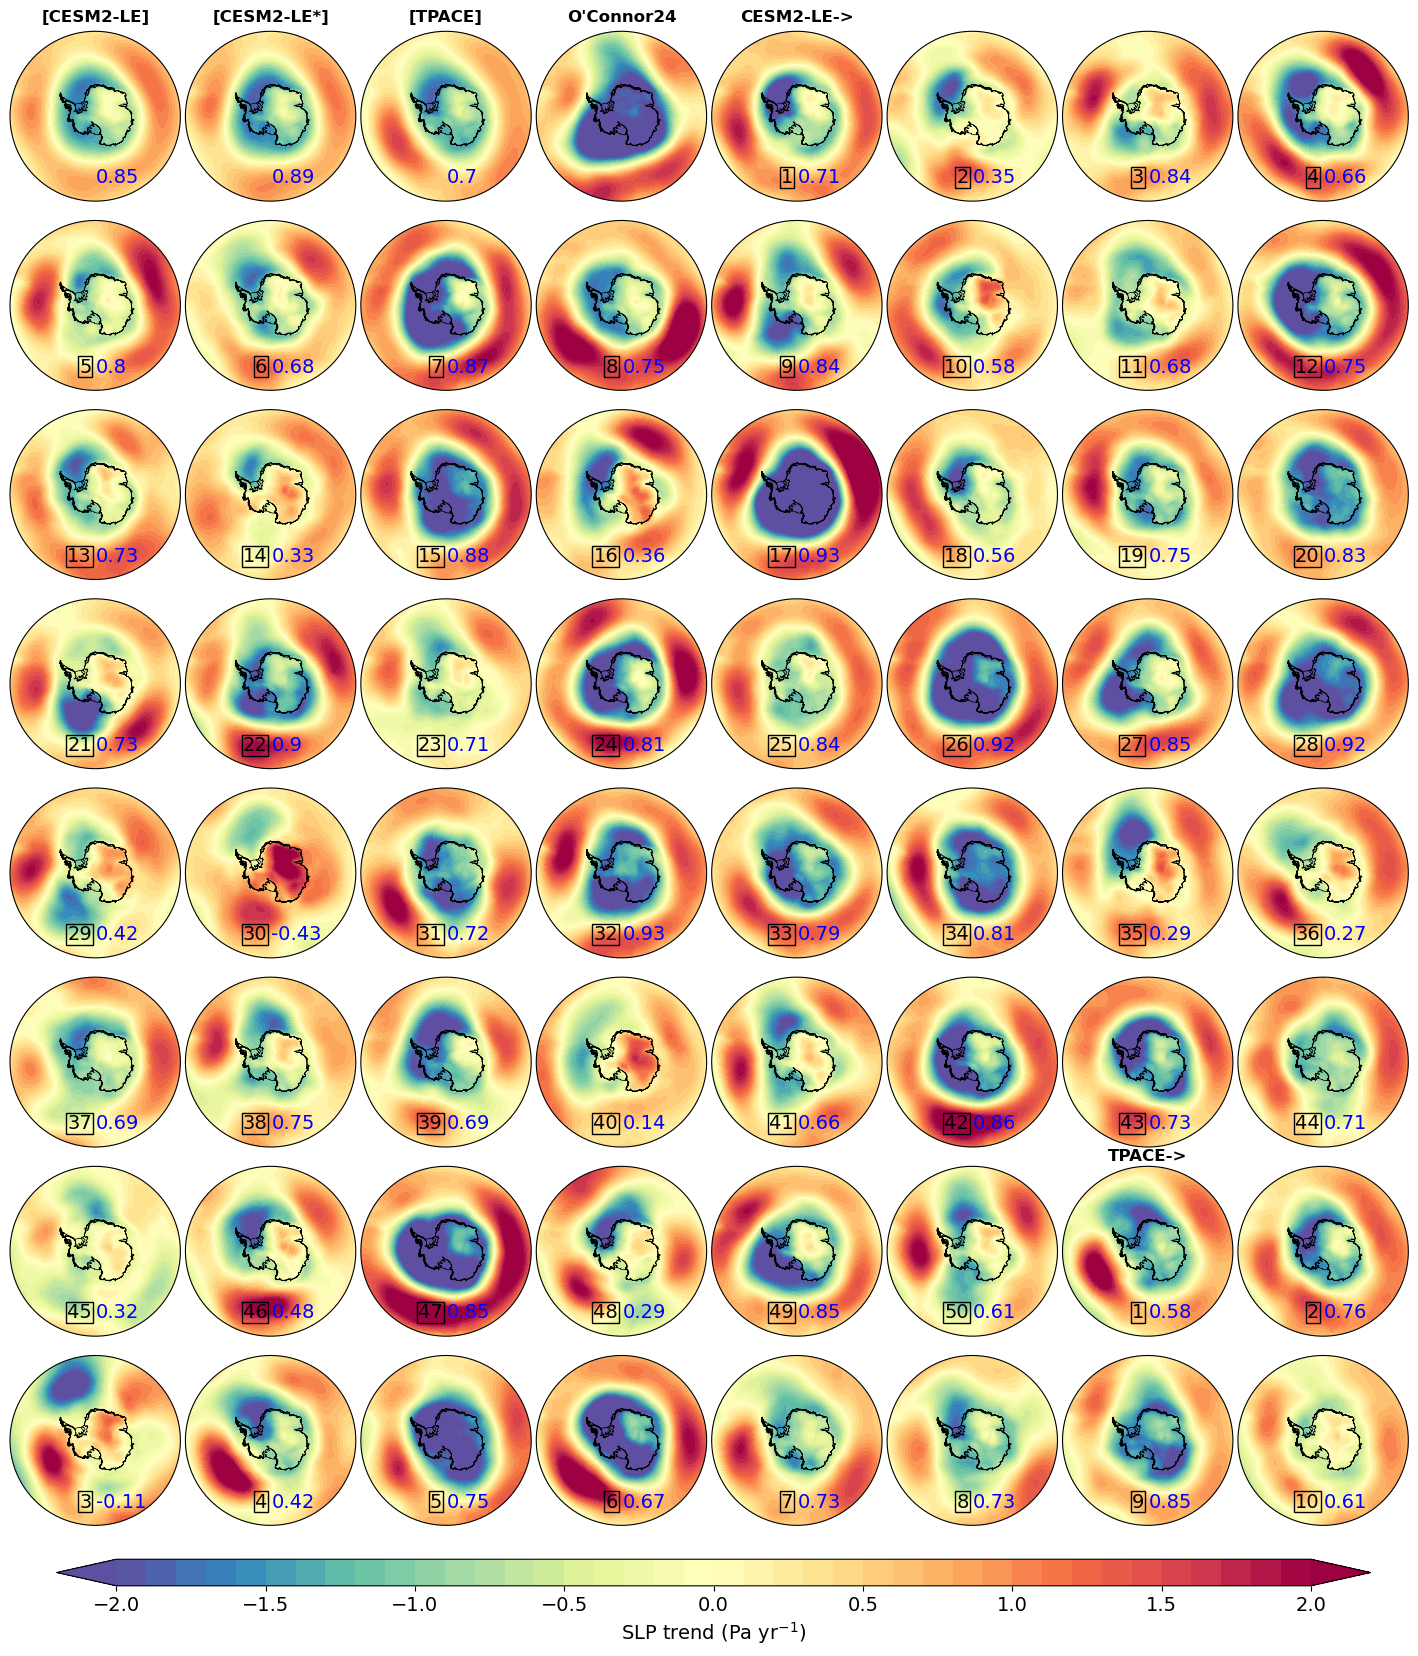

In [22]:
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10+2
size_label = 12+2
size_tick = 12+2
size_text = 12+2

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('[CESM2-LE]', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(50000, -4800000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('[CESM2-LE*]', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(50000, -4800000, round(PSL_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('[TPACE]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(50000, -4800000, round(PSL_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('O\'Connor24', pad=8, fontsize=size_title, fontweight='bold')


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title, fontweight='bold')
        ax.text(-1150000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-2000000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -4800000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


# CESM2-TPACE
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_TPACE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('TPACE->', pad=5, fontsize=size_title, fontweight='bold')
        ax.text(-1150000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-2000000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -4800000, round(PSL_TPACE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('../plot/C2_map_AIS_PSL_trend_CESM2-LE_TPACE_ensemble_OC24_epoch_2501.jpg',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)
#plt.show()

In [ ]:
# Save as pdf format
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10+2
size_label = 12+2
size_tick = 12+2
size_text = 12+2

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('[CESM2-LE]', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(50000, -4800000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('[CESM2-LE*]', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(50000, -4800000, round(PSL_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('[TPACE]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(50000, -4800000, round(PSL_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('O\'Connor24', pad=8, fontsize=size_title, fontweight='bold')


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title, fontweight='bold')
        ax.text(-1150000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-2000000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -4800000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


# CESM2-TPACE
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_TPACE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('TPACE->', pad=5, fontsize=size_title, fontweight='bold')
        ax.text(-1150000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-2000000, -4800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -4800000, round(PSL_TPACE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig(
    '../plot/C2_map_AIS_PSL_trend_CESM2-LE_TPACE_ensemble_OC24_epoch_2501.pdf',
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

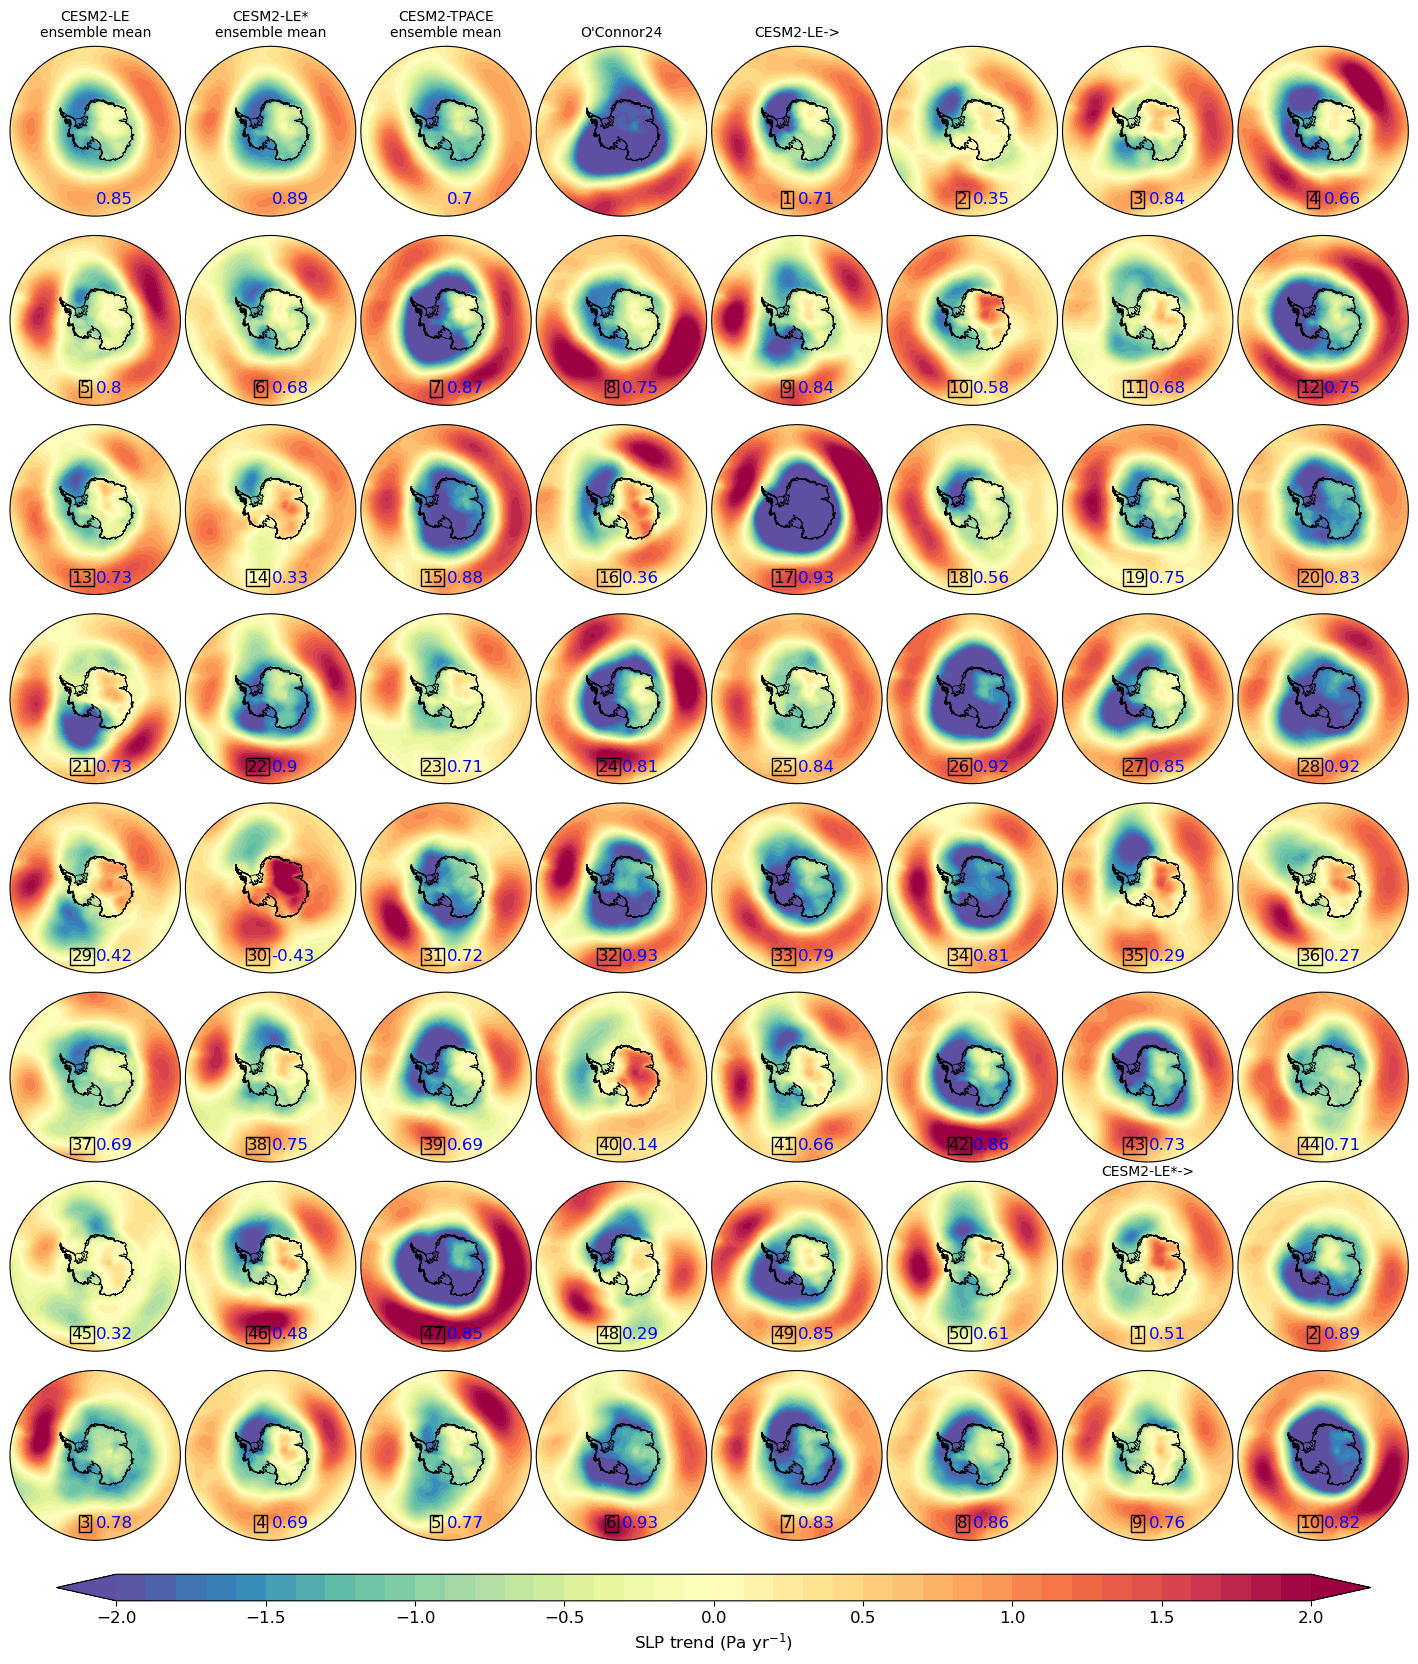

In [41]:
# With LE* instead of TPACE
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10
size_label = 12
size_tick = 12
size_text = 12

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('CESM2-LE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax1.text(50000, -5200000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('CESM2-LE*\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax2.text(50000, -5200000, round(PSL_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('CESM2-TPACE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax3.text(50000, -5200000, round(PSL_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('O\'Connor24', pad=8, fontsize=size_title)


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


# CESM2-LE*
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE10_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE*->', pad=5, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_LE10_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('map_AIS_PSL_trend_CESM2-LE_LE10_ensemble_OC24_epoch.jpg',dpi=300)
plt.show()

#### version3 - O'Connor24-TPACE

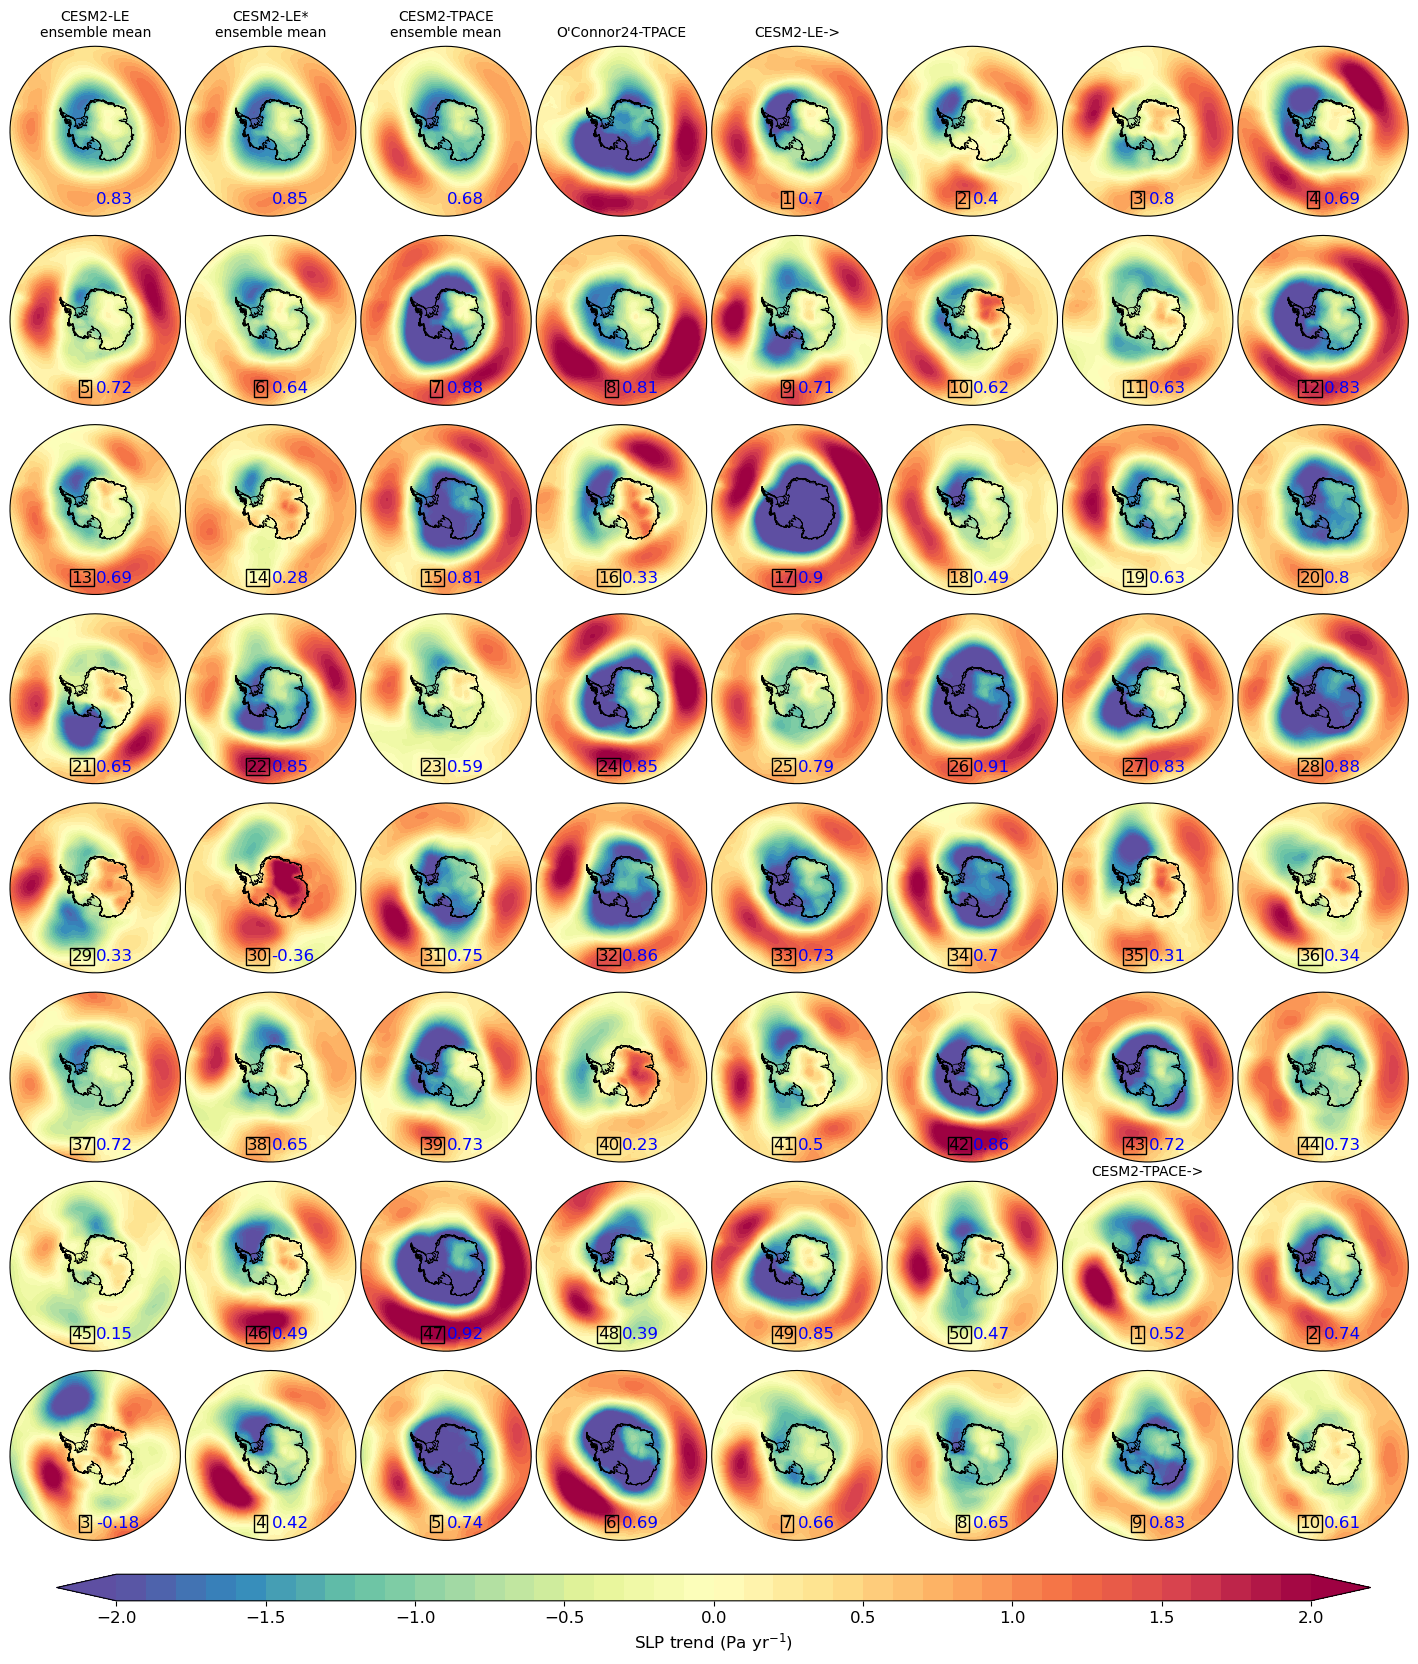

In [41]:
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_PSL = np.arange(-2., 2.01, 0.1)
ticks_PSL = np.arange(-2., 2.01, 0.5)

size_title = 10
size_label = 12
size_tick = 12
size_text = 12

cmap1='Spectral_r'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -40)

im1=ax1.contourf(lon_full, lat, PSL_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax1.set_title('CESM2-LE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax1.text(50000, -5200000, round(PSL_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -40)

im2=ax2.contourf(lon_full, lat, PSL_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax2.set_title('CESM2-LE*\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax2.text(50000, -5200000, round(PSL_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -40)

im3=ax3.contourf(lon_full, lat, PSL_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax3.set_title('CESM2-TPACE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax3.text(50000, -5200000, round(PSL_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# O'Connor
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -40)

im4=ax4.contourf(lon_OC_full, lat_OC, PSL_OC_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')
ax4.set_title('O\'Connor24-TPACE', pad=8, fontsize=size_title)


######################### Esemble members #########################
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


# CESM2-TPACE
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -40)

    im=ax.contourf(lon_full, lat, PSL_TPACE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_PSL, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-TPACE->', pad=5, fontsize=size_title)
        ax.text(-1100000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1700000, -5200000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(50000, -5200000, round(PSL_TPACE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')


#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_PSL, ticks=ticks_PSL)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SLP trend (Pa yr$^{-1}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('map_AIS_PSL_trend_CESM2-LE_TPACE_ensemble_OC24TPACE_epoch.jpg',dpi=300)
plt.show()